In [459]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import stirling2
import math
from copy import copy

In [460]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [461]:
rng = np.random.default_rng(8)

# SDP Moment Equations for Interacting Birth Death

Extend 1 species setup from 'independent_birth_death' to 2 species for interacting birth death

## Code

In [462]:
def compute_order(alpha):
    order = 0
    for alpha_i in alpha:
        order += alpha_i
    return order

In [463]:
def compute_Nd(d, S=2):
    '''Number of moments of order <= d (S species)'''
    Nd = math.factorial(S + d) // (math.factorial(d) * math.factorial(S))
    return Nd

In [464]:
def compute_powers(d, S=2):
    '''Compute the Nd powers of order <= d (S species)'''

    # all powers
    powers = [[0 for s in range(S)]]

    # powers of order d = 0
    powers_prev = [[0 for s in range(S)]]

    # for order d = 1, ..., d
    for order in range(1, d + 1):

        # store powers of order d
        powers_current = []

        # for each power of order d - 1
        for alpha in powers_prev:

            # for each index
            for i in range(S):

                # add 1 to power at index
                alpha_new = copy(alpha)
                alpha_new[i] += 1

                # store (avoid repeats)
                if alpha_new not in powers_current:
                    powers_current.append(alpha_new)

        # update d - 1 powers
        powers += powers_current

        # update overall powers
        powers_prev = powers_current

    return powers

In [465]:
def compute_A(alpha, d):
    '''
    Moment equation coefficient matrix
    NOTE: must have order of alpha <= d - 1

    Args:
        alpha: moment order for equation (d/dt mu^alpha = 0)
        d: maximum moment order used

    Returns:
        A: (5, Nd) matrix of coefficients
    '''

    if compute_order(alpha) > d - 1:
        raise NotImplementedError("Maximum moment order 'd' too small for order 'alpha' moment equation: involves moments of order higher than d - 1.")

    # reaction settings
    R = 5
    S = 2

    xs = sp.symbols([f'x{i}' for i in range(S)])

    # reaction propensity polynomials
    props = [
        1,
        xs[0],
        1,
        xs[1],
        xs[0] * xs[1]
    ]

    # reaction vectors
    vrs = [
        [1, 0],
        [-1, 0],
        [0, 1],
        [0, -1],
        [-1, -1]
    ]

    # number of moments of order <= d
    Nd = compute_Nd(d, S)

    # get powers of order <= d
    powers = compute_powers(d, S)

    # setup matrix
    A = np.zeros((R, Nd))

    for r, prop in enumerate(props):

        # expand b(x) * ((x + v_r)**alpha - x**alpha)
        term_1 = 1
        term_2 = 1
        for i in range(S):
            term_1 = term_1 * (xs[i] + vrs[r][i])**alpha[i]
            term_2 = term_2 * xs[i]**alpha[i]
        poly = sp.Poly(prop * (term_1 - term_2), xs)

        # loop over terms
        for xs_power, coeff in zip(poly.monoms(), poly.coeffs()):

            # get matrix index
            col = powers.index(list(xs_power))

            # store
            A[r, col] = coeff

    return A

In [466]:
def compute_B(beta, d, S=2):
    '''
    Capture efficiency moment scaling matrix

    Args:
        beta: per cell capture efficiency sample
        d: maximum moment order used

    Returns:
        B: (Nd, Nd) matrix of coefficients
    '''

    # number of moments of order <= d
    Nd = compute_Nd(d, S)

    # compute powers of order <= d
    powers = compute_powers(d, S)

    # compute beta moments of order <= d
    y_beta = np.zeros(d + 1)
    for l in range(d + 1):
        y_beta[l] = np.mean(beta**l)

    def falling_factorial(n, k):
        val = 1
        for i in range(k):
            val *= (n - i)
        return val

    def binomial_moment(n, p, l):
        val = 0
        for k in range(l + 1):
            val += falling_factorial(n, k) * stirling2(l, k) * p**k
        return val

    # setup matrix
    B = np.zeros((Nd, Nd))

    p = sp.Symbol('p')
    xs = sp.symbols([f'x{i}' for i in range(S)])

    # for each moment power
    for row, alpha in enumerate(powers):

        # setup polynomail
        poly_alpha = 1

        # for each species
        for i in range(S):

            # compute moment expression for E[Xi^alphai] in xi
            moment = binomial_moment(xs[i], p, alpha[i])
            poly = sp.Poly(moment, p, xs[i])

            # multiply
            poly_alpha = poly_alpha * poly

        # loop over terms
        for (beta_power, *xs_power), coeff in zip(poly_alpha.monoms(), poly_alpha.coeffs()):

            # get matrix index
            col = powers.index(xs_power)

            B[row, col] += coeff * y_beta[beta_power]

    return B

In [467]:
def add_powers(*powers, S):
    plus = [0 for i in range(S)]
    for i in range(S):
        for power in powers:
            plus[i] += power[i]
    return plus

## Moment matrices

- hopefully e_1 = [1, 0, ...]

In [468]:
def construct_M_0(y, d, S):
    '''Moment matrix variable constructor (s = 0).'''
    D = math.floor(d / 2)
    powers_D = compute_powers(D, S)
    powers_d = compute_powers(d, S)
    ND = compute_Nd(D, S)
    M_0 = [[0 for j in range(ND)] for i in range(ND)]
    for alpha_index, alpha in enumerate(powers_D):
        for beta_index, beta in enumerate(powers_D):
            plus = add_powers(alpha, beta, S=2)
            plus_index = powers_d.index(plus)
            M_0[alpha_index][beta_index] = y[plus_index].item()
    M_0 = gp.MVar.fromlist(M_0)
    return M_0

In [469]:
def construct_M_s(y, d, s, S):
    '''Moment matrix variable constructor (s).'''
    D = math.floor((d - 1) / 2)
    powers_D = compute_powers(D, S)
    powers_d = compute_powers(d, S)
    ND = compute_Nd(D, S)
    M_s = [[0 for j in range(ND)] for i in range(ND)]
    e_s = [1 if i == (s - 1) else 0 for i in range(S)]
    for alpha_index, alpha in enumerate(powers_D):
        for beta_index, beta in enumerate(powers_D):
            plus = add_powers(alpha, beta, e_s, S=2)
            plus_index = powers_d.index(plus)
            M_s[alpha_index][beta_index] = y[plus_index].item()
    M_s = gp.MVar.fromlist(M_s)
    return M_s

In [470]:
def base_model(model, OB_bounds, beta, d, time_limit=300):
    '''
    Construct 'base model' with semidefinite constraints removed to give NLP

    Args:
        model: empty gurobi model object
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector
        d: maximum moment order used
        time_limit: optimization time limit

    Returns:
        model: gurobi model object with NLP constraints (all but semidefinite)
        variables: dict for model variable reference
    '''

    # model settings
    model.Params.TimeLimit = time_limit
    K = 100

    # helpful values
    R = 5
    S = 2
    Nd = compute_Nd(d)
    moment_powers = compute_powers(d - 1, S)

    # variables
    y = model.addMVar(shape=Nd, vtype=GRB.CONTINUOUS, name="y", lb=0)
    k = model.addMVar(shape=R, vtype=GRB.CONTINUOUS, name="k", lb=0, ub=K)

    # moment matrices
    M_0 = construct_M_0(y, d, S)
    M_1 = construct_M_s(y, d, 1, S)
    
    # constraints

    # confidence interval bounds on OB moments
    y_lb = OB_bounds[0, :]
    y_ub = OB_bounds[1, :]

    # B scaling matrix
    B = compute_B(beta, d, S)

    # moment bounds
    model.addConstr(B @ y <= y_ub, name="y_UB")
    model.addConstr(B @ y >= y_lb, name="y_LB")

    # moment equations
    for alpha in moment_powers:
        A_alpha_d = compute_A(alpha, d)
        model.addConstr(k.T @ A_alpha_d @ y == 0, name=f"ME_{alpha}_{d}")

    # base
    model.addConstr(y[0] == 1, name="y0_base")

    # fixed parameter
    model.addConstr(k[1] == 1, name="k2_fixed")

    # variable dict
    variables = {
        'y': y,
        'k': k,
        'M_0': M_0,
        'M_1': M_1
    }

    return model, variables

In [471]:
def optimize(model):
    '''Optimize model with no objective, return status.'''

    # optimize
    model.setObjective(0, GRB.MINIMIZE)
    model.optimize()
    status = status_codes[model.status]

    return model, status

In [473]:
def semidefinite_cut(model, variables, print_evals=False):
    '''
    Check semidefinite feasibility of NLP feasible point
    Feasible: stop
    Infeasible: add cutting plane

    Args:
        model: optimized NLP model
        variables: model variable reference dict
        print_evals: option to display moment matrix eigenvalues (semidefinite condition)

    Returns:
        model: model with any cutting planes added
        bool: semidefinite feasibility status
    '''

    # get moment matrix values
    M_0_val = variables['M_0'].X
    M_1_val = variables['M_1'].X

    # check semidefinite
    evals_0, evecs_0 = np.linalg.eigh(M_0_val)
    evals_1, evecs_1 = np.linalg.eigh(M_1_val)

    if print_evals:
        print("Moment matices eigenvalues:")
        print(evals_0)
        print(evals_1)

    # positive eigenvalues
    if (evals_0 >= 0).all() and (evals_1 >= 0).all():

        print("SDP feasible\n")
    
        return model, True

    # negative eigenvalue
    else:

        print("SDP infeasible")

        if evals_0[0] < 0:

            # get eigenvector
            v = evecs_0[:, 0]

            # add cutting plane
            model.addConstr(v.T @ variables['M_0'] @ v >= 0, name="Cut_0")

            print("M_0 cut added\n")

        if evals_1[0] < 0:

            # get eigenvector
            v = evecs_1[:, 0]

            # add cutting plane
            model.addConstr(v.T @ variables['M_1'] @ v >= 0, name="Cut_1")

            print("M_1 cut added\n")

    return model, False

## Cutting planes: all negative eigenvalues

In [493]:
def semidefinite_cut_all(model, variables, print_evals=False):
    '''
    Check semidefinite feasibility of NLP feasible point
    Feasible: stop
    Infeasible: add cutting plane (ALL negative eigenvalues)

    Args:
        model: optimized NLP model
        variables: model variable reference dict
        print_evals: option to display moment matrix eigenvalues (semidefinite condition)

    Returns:
        model: model with any cutting planes added
        bool: semidefinite feasibility status
    '''

    # get moment matrix values
    M_0_val = variables['M_0'].X
    M_1_val = variables['M_1'].X

    # check semidefinite
    evals_0, evecs_0 = np.linalg.eigh(M_0_val)
    evals_1, evecs_1 = np.linalg.eigh(M_1_val)

    if print_evals:
        print("Moment matices eigenvalues:")
        print(evals_0)
        print(evals_1)

    # positive eigenvalues
    if (evals_0 >= 0).all() and (evals_1 >= 0).all():

        print("SDP feasible\n")
    
        return model, True

    # negative eigenvalue
    else:

        print("SDP infeasible\n")

        # for each M_0 eigenvalue
        for i, lam in enumerate(evals_0):

            # if negative
            if lam < 0:

                # get evector
                v = evecs_0[:, i]

                # add cutting plane
                model.addConstr(v.T @ variables['M_0'] @ v >= 0, name="Cut_0")
            
                print("M_0 cut added")

        # for each M_1 eigenvalue
        for i, lam in enumerate(evals_1):

            # if negative
            if lam < 0:

                # get evector
                v = evecs_1[:, i]

                # add cutting plane
                model.addConstr(v.T @ variables['M_1'] @ v >= 0, name="Cut_1")

                print("M_1 cut added")

        print("")

    return model, False

In [491]:
def feasibility_test(OB_bounds, beta, d):
    '''
    Full feasibility test of birth death model via following algorithm

    Optimize NLP
    Infeasible: stop
    Feasible: check SDP feasibility
        Feasible: stop
        Infeasible: add cutting plane and return to NLP step

    Args:
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector
        d: maximum moment order used

    Returns:
        None
    '''

    # silent
    options = {'OutputFlag': 0}

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-SDP', env=env) as model:

            # construct base model (no semidefinite constraints)
            model, variables = base_model(model, OB_bounds, beta, d)

            # check feasibility
            model, status = optimize(model)

            # while feasible
            while status == "OPTIMAL":

                print("NLP feasible")

                # check semidefinite feasibility
                model, semidefinite_feas = semidefinite_cut_all(model, variables, print_evals=True)

                # semidefinite feasible
                if semidefinite_feas:
                    break

                # semidefinite infeasible
                else:

                    # check feasibility with added cut
                    model, status = optimize(model)

            # if infeasible
            if status == "INFEASIBLE":
                print("SDP infeasible")

In [485]:
def bootstrap(sample, d, S=2, N=1000):
    '''
    Estimate bootstrap intervals of sample moments up to order d

    Args:
        sample: integer sample of length n
        d: maximum moment order to estimate
        S: number of species
        N: number of bootstrap samples

    Returns:
        y_bounds: (2, Nd) array of moment confidence intervals
    '''

    # helpful values
    powers = compute_powers(d, S)
    Nd = compute_Nd(d, S)

    # get sample size
    n = len(sample)

    # separate sample pairs
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(N, n))

    # split into 2 N x n arrays
    x1_boot = boot[:, :, 0]
    x2_boot = boot[:, :, 1]

    # estimate
    y_bounds = np.zeros((2, Nd))
    for i, alpha in enumerate(powers):

        # raise boot to powers
        x1_boot_alpha = x1_boot**alpha[0]
        x2_boot_alpha = x2_boot**alpha[1]

        # multiply (N x n)
        boot_alpha = x1_boot_alpha * x2_boot_alpha

        # mean over sample axis (N x 1)
        moment_estimates = np.mean(boot_alpha, axis=1)

        # quantile over boot axis (2 x 1)
        moment_interval = np.quantile(moment_estimates, [0.025, 0.975])

        # store
        y_bounds[:, i] = moment_interval

    return y_bounds

In [477]:
def downsample_data(sample, b):

    n = len(sample)

    # capture efficiency
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=1000)

    # split
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # downsample
    x1_downsample = rng.binomial(x1_sample, beta).tolist()
    x2_downsample = rng.binomial(x2_sample, beta).tolist()

    # combine
    downsample = list(zip(x1_downsample, x2_downsample))

    return downsample, beta

## Bootstrap test

In [478]:
from interaction_inference.simulation import gillespie_birth_death

In [479]:
params = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}
n = 1000

sample = gillespie_birth_death(params, n)

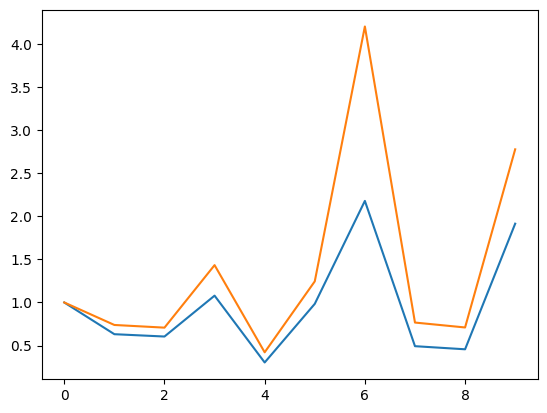

In [480]:
estimates = bootstrap(sample, 3)
plt.plot(estimates[0, :])
plt.plot(estimates[1, :])

## Test

In [481]:
# settings
k1 = 5
k2 = 1
k_reg = 5
b = 1
n = 1000
N = 1000

# sample
params = {
    'k_tx_1': k1,
    'k_tx_2': k1,
    'k_deg_1': k2,
    'k_deg_2': k2,
    'k_reg': k_reg
}
sample = gillespie_birth_death(params, n)

# downsample
downsample, beta = downsample_data(sample, b)

# mean expression level
print(f"Mean expression {np.mean(downsample)}")

Mean expression 0.6475


In [495]:
# settings
d = 3

# bootstrap
y_bounds = bootstrap(downsample, d)

# test feasibility
feasibility_test(y_bounds, beta, d)

NLP feasible
Moment matices eigenvalues:
[0.21877135 3.20543646 5.36307787]
[ 0.35805368  1.39957416 23.04316377]
SDP feasible



## Telegraph test

In [496]:
from interaction_inference.simulation import gillespie_telegraph

In [512]:
# settings
k_on = 0.1
k_off = 1
k1 = 5
k2 = 1
k_reg = 1
b = 0
n = 1000
N = 1000

# sample
params = {
    'k_on_1': k_on,
    'k_on_2': k_on,
    'k_off_1': k_off,
    'k_off_2': k_off,
    'k_tx_1': k1,
    'k_tx_2': k1,
    'k_deg_1': k2,
    'k_deg_2': k2,
    'k_reg': k_reg
}
sample = gillespie_telegraph(params, n)

# downsample
downsample, beta = downsample_data(sample, b)

# mean expression level
print(f"Mean expression {np.mean(downsample)}")

Mean expression 0.4515


In [513]:
# settings
d = 6

# bootstrap
y_bounds = bootstrap(downsample, d)

# test feasibility
feasibility_test(y_bounds, beta, d)

NLP feasible
Moment matices eigenvalues:
[-3.32474411e+01 -1.31641087e+00  2.88388558e-02  5.01411427e-01
  7.34773371e-01  9.87236466e-01  1.13920427e+00  3.04911421e+00
  8.43305278e+02  1.44634463e+03]
[-5.79617037e-02  6.07697403e-03  8.99189320e-02  4.72969544e-01
  6.01825712e+00  3.33680526e+02]
SDP infeasible

M_0 cut added
M_0 cut added
M_1 cut added

NLP feasible
Moment matices eigenvalues:
[-1.11797369e+00 -1.04533145e-01  3.60097057e-02  5.19571437e-01
  7.48267719e-01  1.03897355e+00  2.16549571e+01  2.94998011e+01
  3.26359831e+03  5.90409062e+03]
[-1.12045415e-02  3.68867379e-02  1.09332961e-01  4.88697340e-01
  5.55971259e+00  3.36763653e+02]
SDP infeasible

M_0 cut added
M_0 cut added
M_1 cut added

NLP feasible
Moment matices eigenvalues:
[6.07970946e-03 3.82163554e-01 4.32059684e-01 4.77918320e-01
 6.97792362e-01 9.45496844e-01 2.05076447e+01 3.11382764e+01
 3.26362616e+03 5.89808278e+03]
[-1.43274160e-01  1.11732288e-02  8.62331804e-02  4.96930242e-01
  2.77639805e+

## Notes

- fixed cut issue: eigenvectors are columns of np.lingalg.eigh's array

- test whether multiple cuts are better (one for each negative eigenvalue) or stick with one per matrix (should it be most or least negative?)